In [1]:
import json
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from typing import Tuple, Dict, Any, List

import matplotlib.pyplot as plt
import seaborn as sns
from src.data.clean import clean
from src.data.wrangle import wrangle

In [2]:
try:
    raw_data = pd.read_csv('FACE/neuropsy_bp.csv', sep=';', low_memory=False)
except Exception as e:
    print(f"An unexpected error occurred: {e}")

df_cleaned = clean(raw_data)
df_cleaned.to_csv('FACE/neuropsy_bp_cleaned.csv', index=False)


df_wrangled, params, wr = wrangle(df_cleaned, conversion_threshold=0.80, cardinality_threshold=10, scale_numeric=True)
df_wrangled.to_csv('FACE/neuropsy_bp_wrangled.csv', index=False)

# Visulaising the data
Perform correlation analysis on the cleaned dataset.

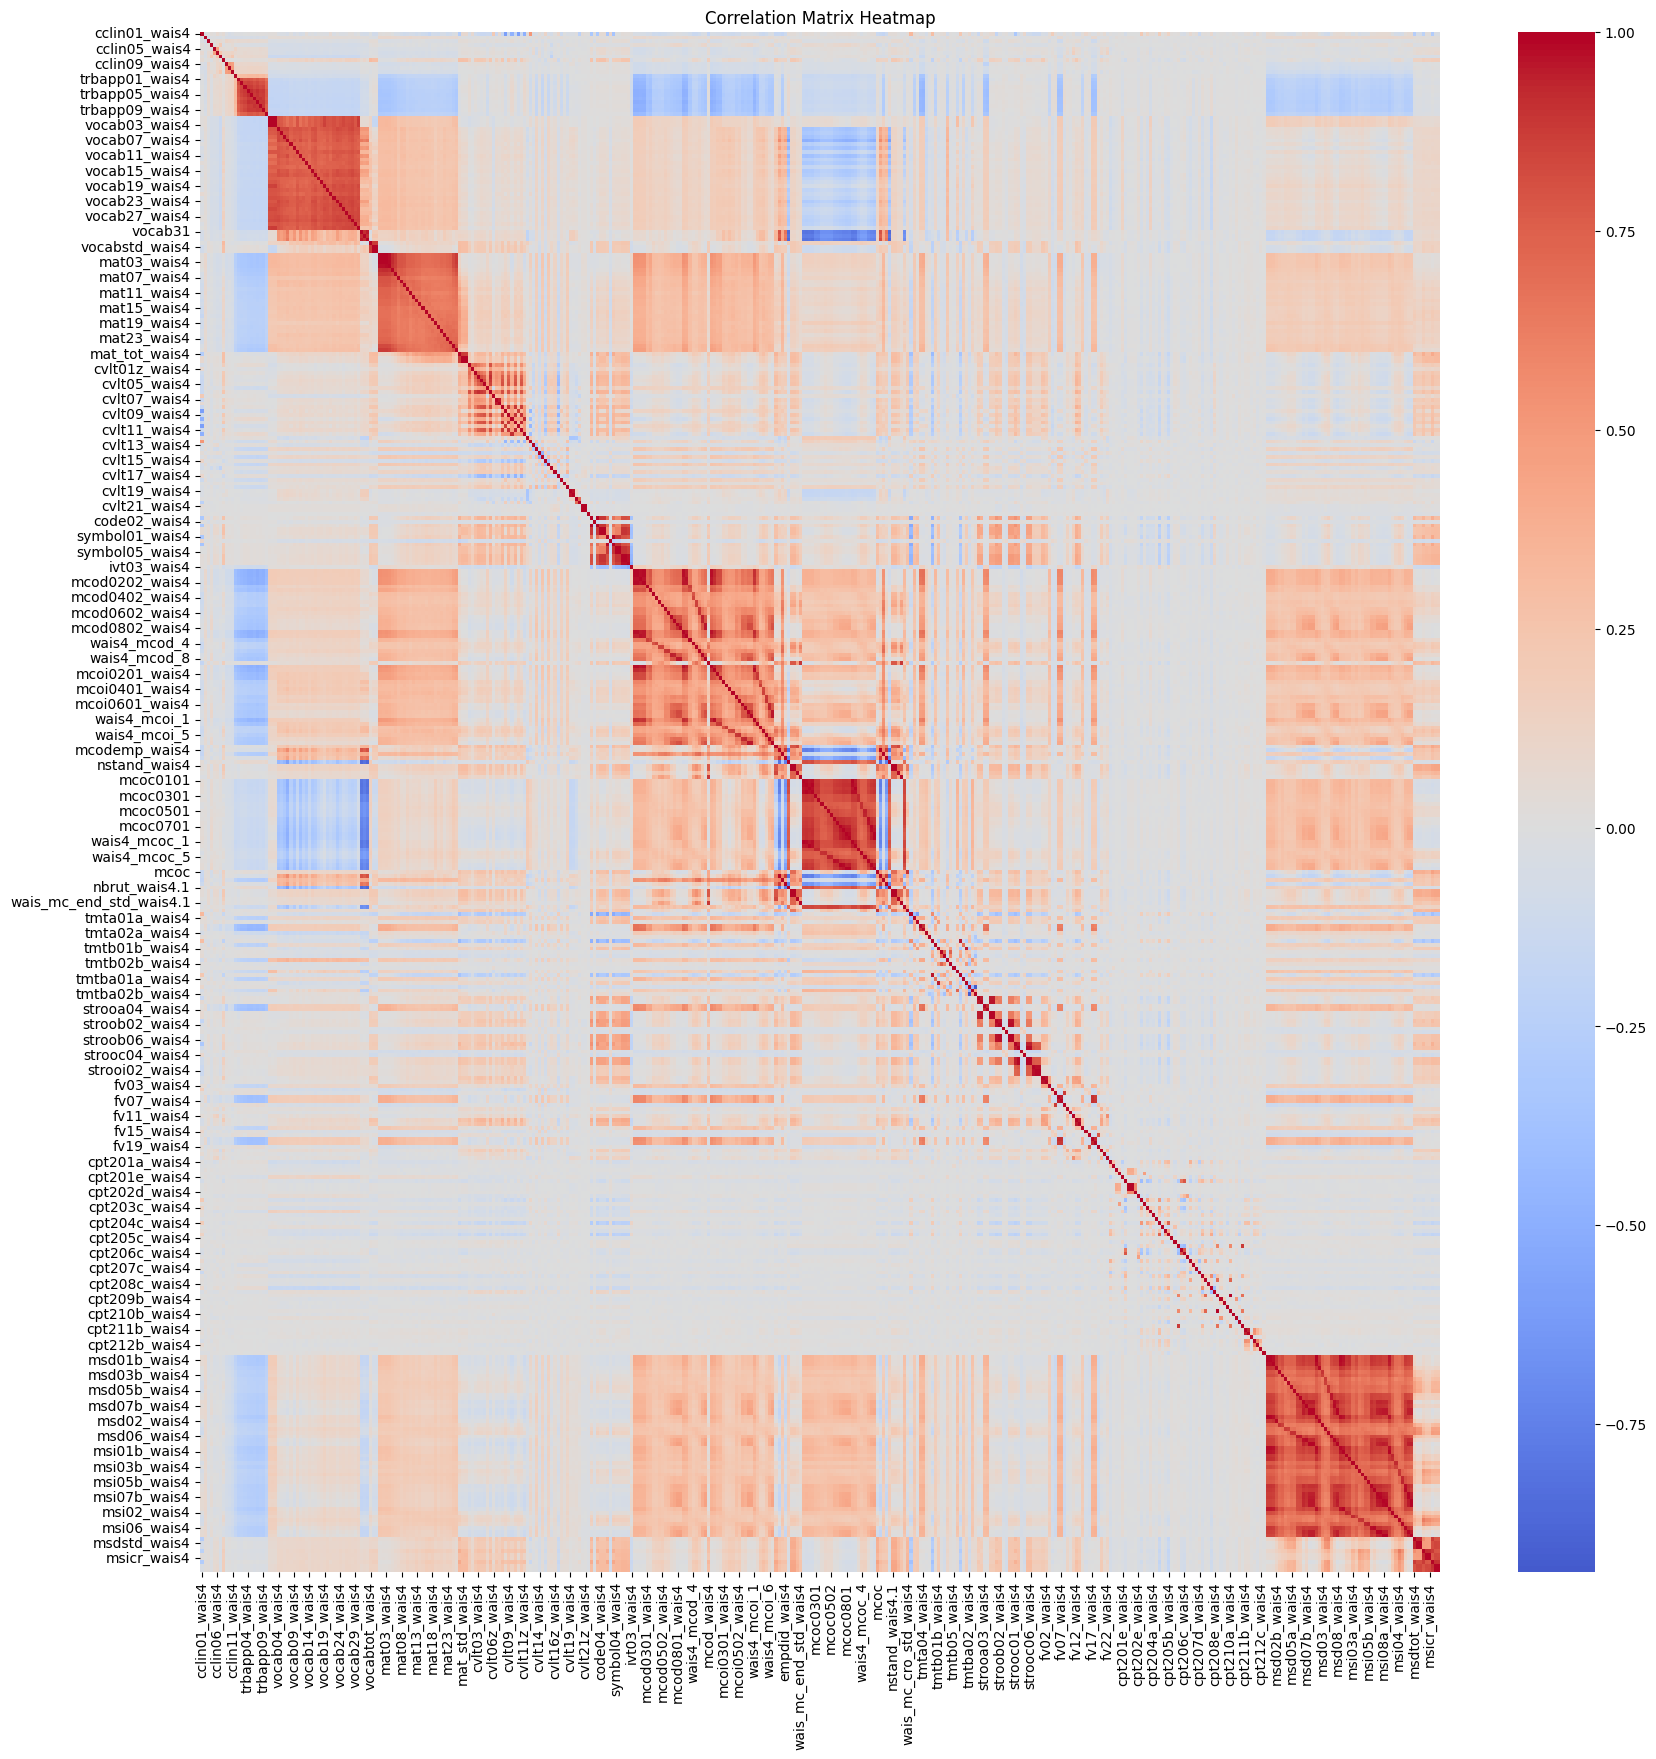

In [3]:
# Calculate the Pearson correlation matrix, visualize it as a heatmap, and identify strong correlations.
# Calculate the correlation matrix
correlation_matrix = df_wrangled.corr(method='pearson')

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(20, 20))  # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title("Correlation Matrix Heatmap")
plt.show()

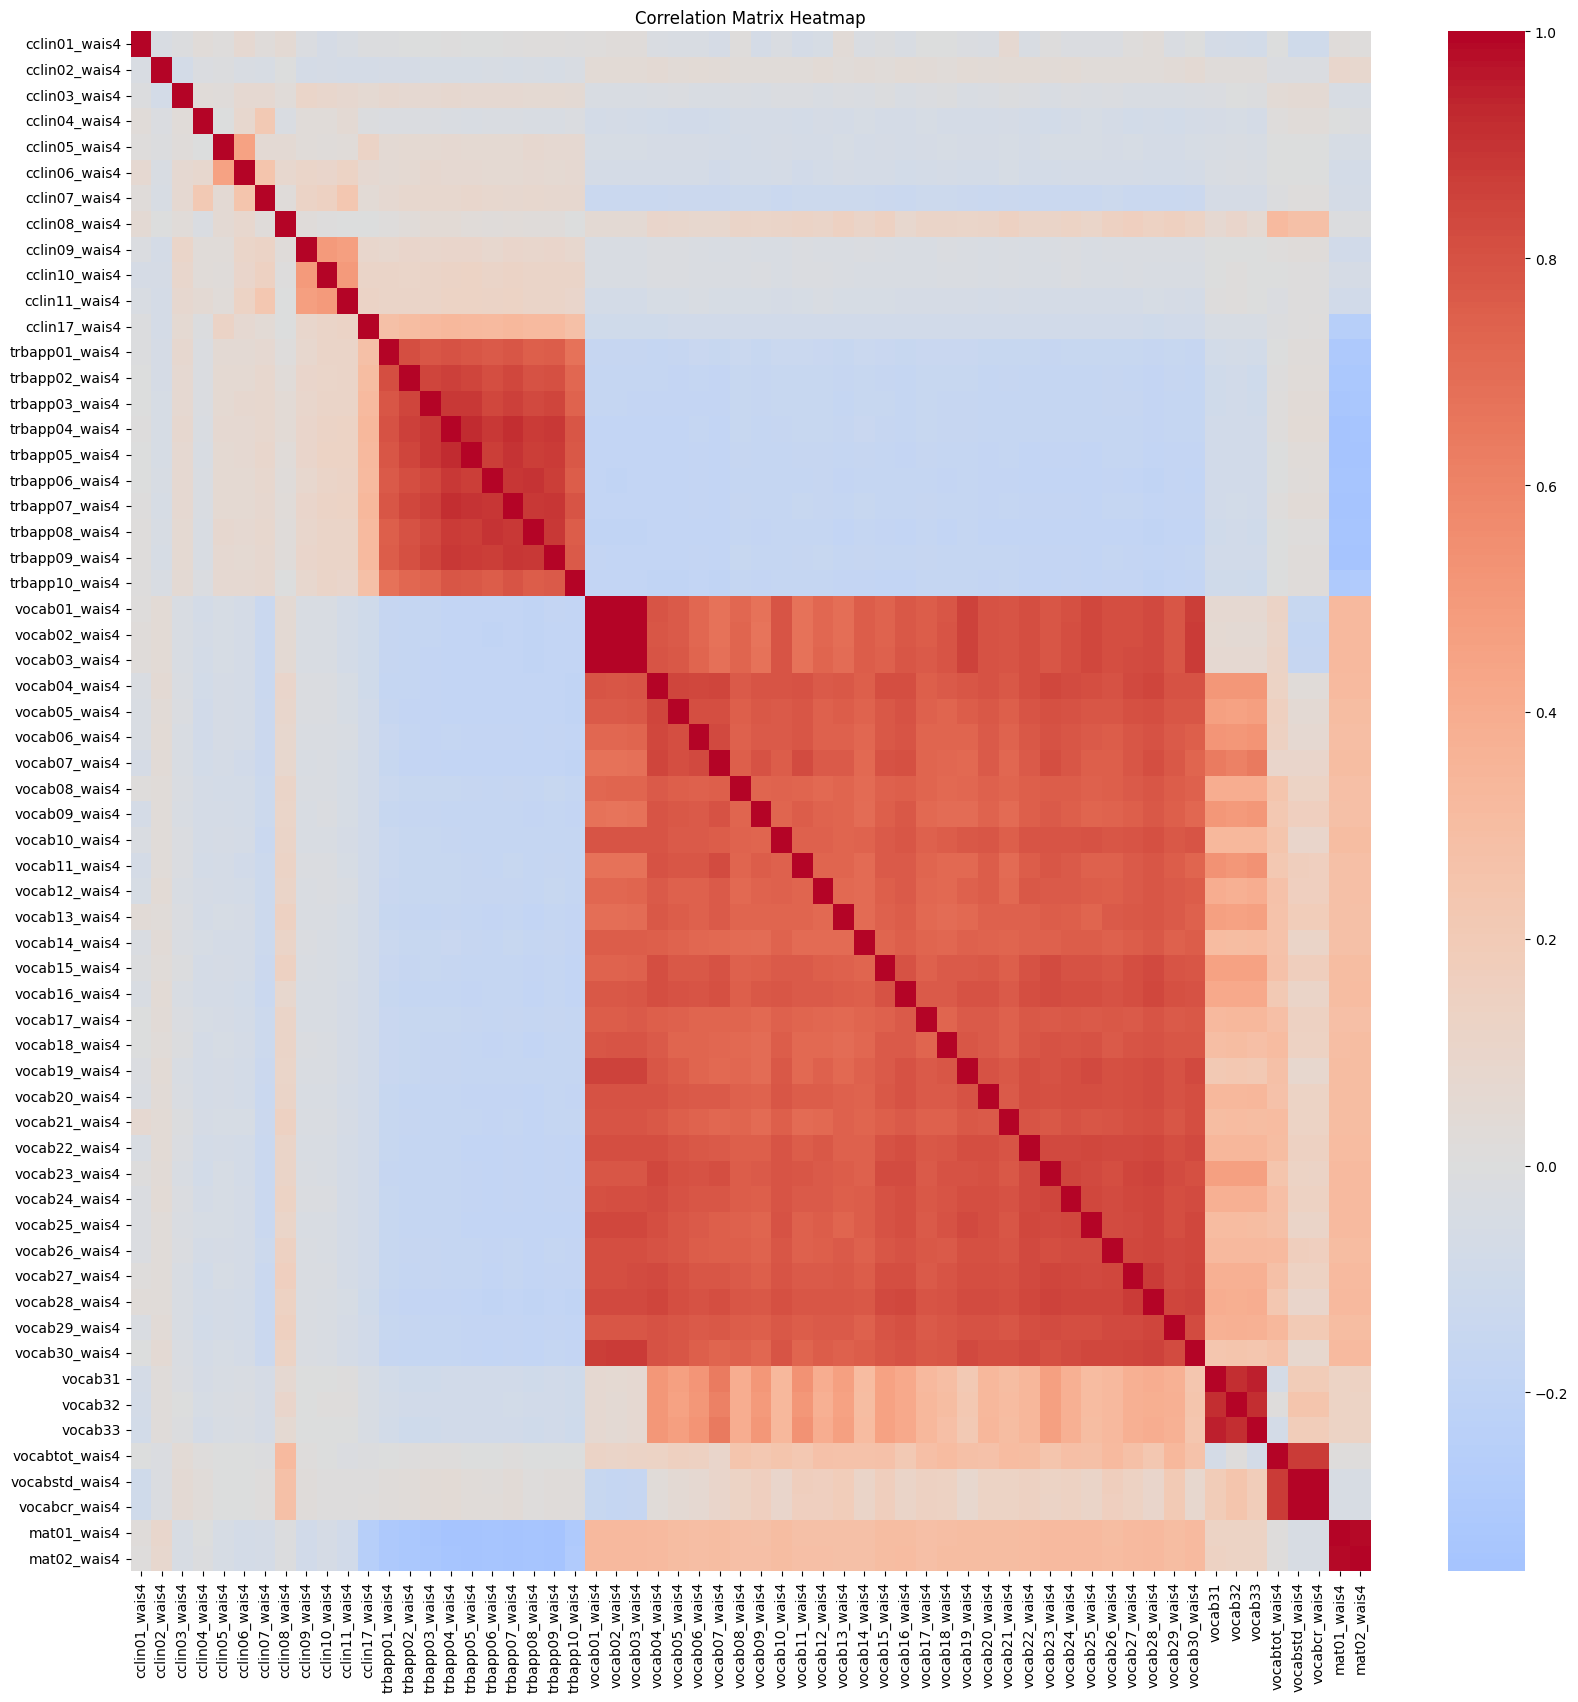

In [4]:
# Calculate the correlation matrix for the first N_COLS columns
N_COLS = 60
correlation_matrix = df_wrangled[df_wrangled.columns[:N_COLS]].corr(method='pearson')

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(20, 20))  # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title("Correlation Matrix Heatmap")
plt.show()


In [5]:
df_partial = df_wrangled[df_wrangled.columns[:N_COLS]]
df_partial.describe()

df_partial.to_csv(f"FACE/neuropsy_bp_partial_n_cols_{N_COLS}.csv", index=False)

# Preprocess data
1. Split into numeric and categorical features
2. Create PreprocessedData containing TabularDataset
    - 2.1. Preprocess data / or not if data is already preprocessed (in our case - yes)
    - 2.2. Examine torch dataset




In [6]:
from src.data.dataset import split_numerical_categorical, reconstruct_dataframe
from src.data.dataset import TabularDataset, preprocess_data, PreprocessedData

In [7]:
num_mat, cat_mat, mapping = split_numerical_categorical(df_partial, cardinality_threshold=7)

num_mat = num_mat.astype(np.float32)
cat_mat = cat_mat.astype(np.int64)

df_partial_converted = reconstruct_dataframe(num_mat, cat_mat, mapping)

In [8]:
data = preprocess_data(num_mat=num_mat, cat_mat=cat_mat, y=None, mapping=mapping,
    test_size=0.25, transform=False, scaling_strategy=None, cat_encoding=None)

In [ ]:
print("X_train shape: ", data.X_train.shape)
print("X_test shape: ", data.X_test.shape)


In [ ]:
from src.data.dataset import split_numerical_categorical, reconstruct_dataframe
from src.data.dataset import TabularDataset, preprocess_data, PreprocessedData

df_wrangled = pd.read_csv('FACE/neuropsy_bp_partial_n_cols_60.csv')
num_mat, cat_mat, mapping = split_numerical_categorical(df_wrangled, cardinality_threshold=7)

num_mat = num_mat.astype(np.float32)
cat_mat = cat_mat.astype(np.int64)

preprocessed_data = preprocess_data(num_mat=num_mat, cat_mat=cat_mat, y=None, mapping=mapping,
    test_size=0.25, transform=False, scaling_strategy=None, cat_encoding=None)